In [1]:
%load_ext autoreload
%autoreload 2

# Wake from Gaussian

In [2]:
import sys
sys.path.append('../')

In [3]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import scipy.constants

mec2 = scipy.constants.value("electron mass energy equivalent in MeV") * 1e6
c_light = scipy.constants.c
e_charge = scipy.constants.e
r_e = scipy.constants.value("classical electron radius")

# Parameters

In [5]:
#sigma_z = 40e-6
#sigma_x = 134e-6 
#rho = 1538.
#gamma = 58708.

sigma_x = 10e-6
sigma_y = 10e-6 
sigma_z = 10e-6 

rho = 1.
gamma = 500.


beta = np.sqrt(1 - 1 / gamma ** 2)
beta2 = 1-1/gamma**2

# Density

In [6]:
xmax = sigma_x*5
xmin = -xmax
xptp = xmax-xmin

ymax = sigma_y*5
ymin = -ymax
yptp = ymax-ymin

zmax = sigma_z*5
zmin = -zmax
zptp = zmax-zmin

nx = 128
ny = 128
nz = 256


dx = xptp/(nx-1)
dy = yptp/(ny-1)
dz = zptp/(nz-1)

deltas = (dx, dy, dz)

xvec = np.linspace(xmin, xmax, nx)
yvec = np.linspace(ymin, ymax, ny)
zvec = np.linspace(zmin, zmax, nz)

X, Y, Z = np.meshgrid( xvec, yvec, zvec, indexing='ij')

In [7]:
from csr3d.dist import lambda_gauss3, lambda_gauss3_prime

In [8]:
density = lambda_gauss3(X, Y, Z)
norm = np.sum(density) * dx * dy *dz
density /= norm
density_prime = lambda_gauss3_prime(X, Y, Z) /norm

# Green function

In [9]:
from csr3d.wake import green_meshes

In [10]:
%%time
Gs = green_meshes(density.shape, deltas, rho=rho, beta=beta)

CPU times: user 9.14 s, sys: 4.5 s, total: 13.6 s
Wall time: 13.9 s


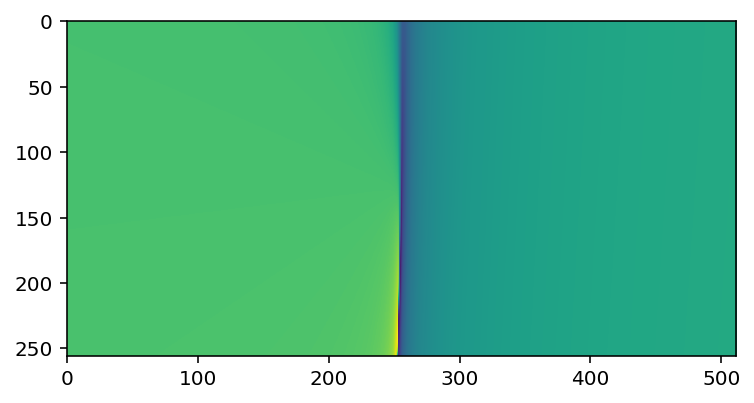

In [11]:
plt.imshow(Gs[:,16,:])

# Convolution

In [12]:
from csr3d.convolution import fftconvolve3

In [13]:
%%time
Ws = fftconvolve3(density_prime, Gs)[0]
Ws.shape

CPU times: user 2.25 s, sys: 434 ms, total: 2.68 s
Wall time: 2.74 s


(128, 128, 256)

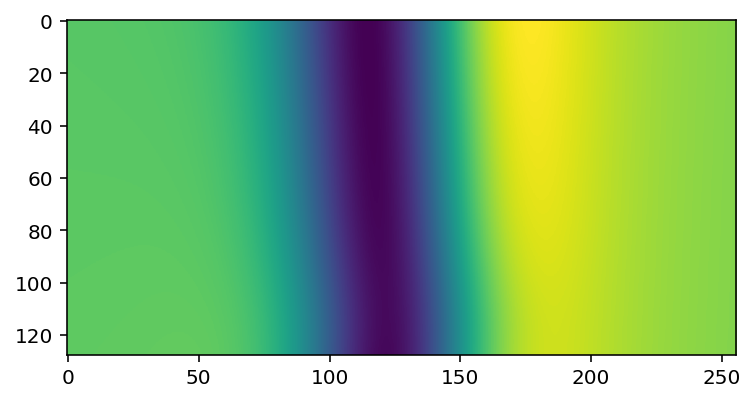

In [14]:
plt.imshow(Ws[:,16,:])

# Wake plot

Compare with Fig. 5 in

https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.23.014402

In [15]:
# Conversion factor for 1/m^2
factor = (beta2 / (rho)) * (dx * dy * dz)
factor

2.431367686264785e-19

In [16]:
# Quickly get nearest indices for +/- sigma_x
ix_pos = np.abs((xvec/sigma_x) - (1)).argmin()
ix_neg = np.abs((xvec/sigma_x) - (-1)).argmin()
(xvec/sigma_x)[ix_pos], (xvec/sigma_x)[ix_neg]

(0.984251968503937, -0.984251968503937)

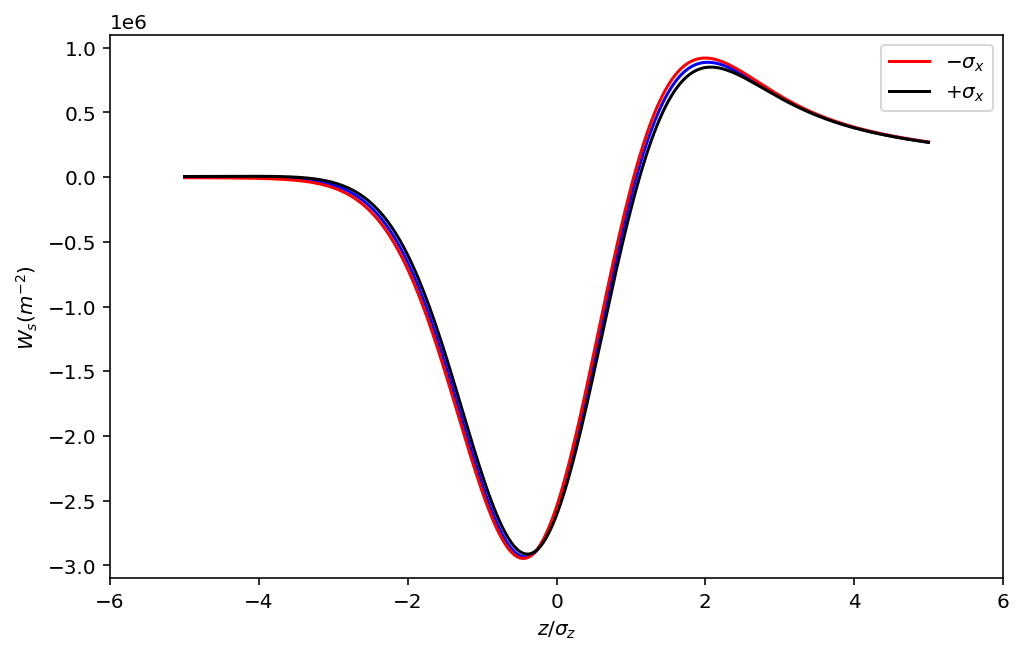

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
ax.set_xlim(-6,6)
ax.set_ylim(-3.1e6,1.1e6)
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$W_s (m^{-2})$')
#for i in range(nx):
#    plt.plot(zvec/sigma_z, Ws[i, ny//2, :]*factor)
ax.plot(zvec/sigma_z, Ws[nx//2, ny//2, :]*factor, color='blue')    
ax.plot(zvec/sigma_z, Ws[ix_neg, ny//2, :]*factor, label=r'$-\sigma_x$', color='red')  
ax.plot(zvec/sigma_z, Ws[ix_pos, ny//2, :]*factor, label=r'$+\sigma_x$', color='black')  
ax.legend()